In [1]:
import os
import pandas as pd
from tqdm import tqdm
import cv2
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt

In [2]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# Image Processing and Computer Vision: CTA projetc

## Look at the dataset

First of all let's start to read the dataset

In [3]:
base_folder = './data/dataset'
data_folder_skymap = './data/dataset/skymaps'
tmp_folder = './tmp'
if not os.path.isdir(tmp_folder):
    os.mkdir(tmp_folder)

In [4]:
df = pd.read_csv(base_folder+'/skymap_set.csv', index_col=False)
df.head()

,File_name,Source-ra,Source-dec,N_sources,Label
0,crab_sky001.fits,83.594197,21.410309,1,yes
1,crab_sky002.fits,81.112909,21.824453,1,yes
2,crab_sky003.fits,0.000000,0.000000,0,no
3,crab_sky004.fits,85.779273,23.729835,3,yes
4,crab_sky004.fits,82.622388,23.012836,3,yes


The function `fits2png` is used for converting a file **.fits** in a grayscale **.png** image. In order to work with a precise interval for pixel values [0..255].

In [5]:
def fits2png(img_fits, filename):
    # take the data
    old_img = img_fits.data
    # extract the image shape
    img_shape = old_img.shape[0]
    # extract minimum and maximu pixel values
    old_vmax = np.max(old_img)
    old_vmin = np.min(old_img)
    
    # build the converted image starting by the pixel intensity values of the fits file
    new_img = np.zeros((img_shape, img_shape))
    # reconstructing it in the interval [0..255] (a grayscale image)
    new_vmax = 255
    new_vmin = 0
    # formula for converting .fits pixel to .png
    new_img = np.round( ( (old_img - old_vmin) / (old_vmax - old_vmin) ) * 255)
    
    # save the new .png image
    name='./data/dataset/temp/'+filename.replace('.fits', '.png')
    cv2.imwrite(name, new_img)
    return new_img

In [6]:
def convertDataset(df,
                   data_folder='./data/dataset',
                   data_folder_skymap=None):
    X = []
    Y = []
    filename = ''
    for i in tqdm(range(len(df))):
        curr = df.iloc[i]
        # if the previous row was for the same file, let's skip the iteration
        if filename == curr['File_name']:
            continue
        # otherwise save the current filename 
        filename = curr['File_name']
        
        # checks the path of the skymap file
        if not data_folder_skymap == None:
            skymap = data_folder_skymap + '/' + filename
        else:
            skymap = data_folder + '/' + filename
        
        # open the skymap
        hdul = fits.open(skymap)
        # and convert it from .fits to .png
        X.append((fits2png(hdul[0].data, filename), skymap))
        # close the skymap
        hdul.close()
        
        # if it is present at least one gamma ray source
        if curr['Label'] == 'yes':
            # let's save all of them converting them in sky coordinates 
            sources = []
            for j in range(curr['N_sources']):
                sources.append(SkyCoord(df.iloc[i+j]['Source-ra'], 
                                        df.iloc[i+j]['Source-dec'], unit=u.deg))
            Y.append((1, sources))
        else:
            Y.append((0, []))
        
    return (X, Y)

Let's extract from our dataset the features from the output we would like to compute.

In [7]:
(X, y) = convertDataset(df, data_folder_skymap=data_folder_skymap)

100%|██████████| 1250/1250 [02:41<00:00,  7.74it/s]


This histogram shows the _labels_ of the images, meaning the amount of images which hasn't and has got at least one source.

<AxesSubplot:title={'center':'Labels histogram'}, xlabel='Label'>

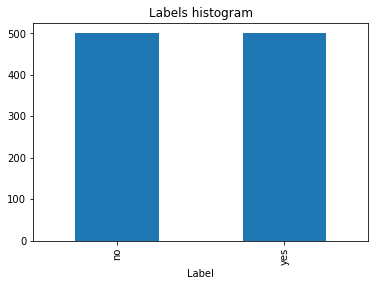

In [8]:
plt.title('Labels histogram')
df.groupby(['File_name', 'Label'], as_index=False).count() \
  .groupby('Label')['Label'].count().plot.bar()

## PCA for plotting data

In this section it is possible visualize the dataset, by using Principal Component Analysis, by extracting 2 components.

In [9]:
from sklearn.decomposition import PCA

First of all it is important to flatten our images.

In [10]:
X_flt = []
for i in range(len(X)):
    X_flt.append(X[i][0].flatten())
X_flt = np.array(X_flt)
X_flt.shape

(1000, 250000)

Now we can proced by computing 2 principal components of them.

In [11]:
pca = PCA(2) # we need 2 principal components.
X_tr = pca.fit_transform(X_flt)
X_tr.shape

(1000, 2)

Finally here we can visualize data, divided by `Label`. _Blue dots_ for images without any sources (`Label=no`) and _red dots_ for images with at least one sources (`Label=yes`).

Even if two principal components are not eanough to separate the our space with an efficient hyperplane, we can still see a coherence in the disposition of the images in the spacce.

Maybe considering an higher number of principal components could be easier to perform a separation amoung the two classes.

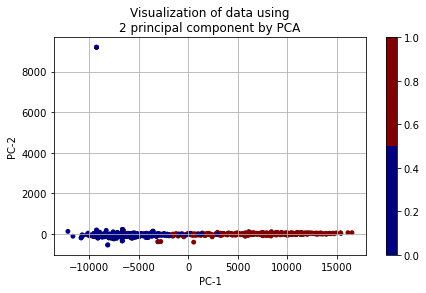

In [12]:
plt.figure(figsize = (7,4))
plt.title('Visualization of data using\n2 principal component by PCA')
plt.grid(True)
c_map = plt.cm.get_cmap('jet', 2)
plt.scatter(X_tr[:, 0], X_tr[:, 1], 
            s = 15, cmap=c_map, 
            c=[y[i][0] for i in range(len(y))])
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

# Label classifier model

First things first, we need to define a threshold which is able to identifying images with at least one source (`Label=yes`) and images without any sources (`Label=no`).

## Preprocessing dataset

Let's now split the dataset in training set and test set.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

And split for both the dataset, the _data_ vector (`X_data_`) from the _file names_ vector (`X_file_`).

In [15]:
X_data_train = np.array([X_train[i][0] for i in range(len(X_train))])
X_file_train = [X_train[i][1] for i in range(len(X_train))]

In [16]:
X_data_test = np.array([X_test[i][0] for i in range(len(X_test))]) 
X_file_test = [X_test[i][1] for i in range(len(X_test))]

Let's do the same for _labels_ vector (`y_label_`) and the _source's coordinates_ vector (`y_coord_`).

In [17]:
y_label_train = [y_train[i][0] for i in range(len(y_train))]
y_coord_train = [y_train[i][1] for i in range(len(y_train))]

In [18]:
y_label_test = [y_test[i][0] for i in range(len(y_test))]
y_coord_test = [y_test[i][1] for i in range(len(y_test))]

### Threshold pseudo-automatic operator

Then, we can start definying functions used for binararization the images, last step before to extract the centroids from images.

Binarization is also used in order to discriminate amoung the two classes of `Label`.

In [ ]:
# this threshold is used for Label classification
def threshIsPresent(img, eps=1):
    return np.max(img)-eps

In [ ]:
# this function extract the pixel value which values amount corresponds to a given 
# percentage inside the histogram of the image
def find_percentile_value(hist, percentile):
    s = 0
    idx = 0
    total_pixel = np.sum(hist)
    while(s < total_pixel*percentile/100):
        s += hist[idx]
        idx += 1
    return idx

In [19]:
# this threshold is used instead for extract sources centroids
def threshExtractSource(img, p=90, c=10):
    hist, bins = np.histogram(img.astype(np.uint8).flatten(),256,[0,256])
    v = find_percentile_value(hist, p)
    T = v + c
    return T

### Preprocessing function

Preprocessing concerns of the following step:
* _Gaussian filter_: in order to denoising the image;
* _Gamma correction_: for intensity transformations;
* _Binary segmentation_: by using thresholding operators. I prefered don't use automatic or adaptive methods because of the properties of the image. It is indeed a very noise and big shape image, where the amount of pixels due to the noise is higher respect to the pixels of sources, resulting in an image which is not clairly bimodal.

In [20]:
import cv2

In [21]:
def preprocess(X,
               f_treshold, 
               sigma=3.5,
               k_gs_size=-1,
               alpha_power=1):
    X1 = np.copy(X)
    if k_gs_size==-1:
        k_gs_size = int(np.ceil((3*sigma))*2+1)
    # Gaussian blur
    X1 = cv2.GaussianBlur(X1, (k_gs_size,k_gs_size), sigma)
    # Gamma correction
    X1 = cv2.convertScaleAbs(X1, alpha=alpha_power)
    # Computing the threshold
    T = f_treshold(X1)
    # Binary segmentation
    ret2, X1 = cv2.threshold(X1,T,255,cv2.THRESH_BINARY)
    return X1

### 2 different kind of preprocessing

About preprocessing, I designed a parametric function for preprocess which can be splitted two different classes:
1. _preprocess for label classification_: in this case the preprocess is designed in a which allows me to extract at least one sources. Indeed the threshold applyied is `threshIsPresent` which extract only a range of pixel from a small window from the maximum value in the image pixels. In this step infact it is not important to understand how many sources there are, I would just know if there is or there isn't a source. In this way it is possible to allow the classifier to work easily.
2. _preprocess for centroids extraction_: after checking there is at least a source inside the image, we would like to extract centroids of sources that inside it. In order to complete this task, it is applyed to the original image a different preprocessing which instead use the threshold computed by  `threshExtractSource`. In this case I try to extract pixels which appartain only to all the sources of gamma ray inside image, considering a percentage of pixels value inside image histograms. N.B.: I couldn't use the above threshold, due to the fact that the previous one is focused to extract _at least one_ source, and this is because of the pixel selection window from the maximum value. Indeed using the same previous threshold would have involved, in images with a lot number gamma ray sources but with someone with a low intensity, in misdetecting low intesity sources. Consequently, a huge amount of _False Negative_.

In [ ]:
sigma=6
k_gs_size=15
p=98
eps_seg=15
alpha_power=1

In [ ]:
# preproces lambda function definition for label classification, 
# implementing threshIsPresent with epsilon value equal to eps_seg
preprocess_SVM = lambda x: preprocess(x,
                                      lambda x: threshIsPresent(x, eps=eps_seg),
                                      sigma=sigma, 
                                      k_gs_size=k_gs_size,
                                      alpha_power=alpha_power)

In [22]:
# preproces lambda function definition for sources extraction, 
# implementing threshExtractSource with percentage value equal to 98%
preprocess_EXS = lambda x: preprocess(x,
                                      lambda x: threshExtractSource(x, p=p),
                                      sigma=sigma, 
                                      k_gs_size=k_gs_size,
                                      alpha_power=alpha_power)

### Preprocess

Let's proced now by preprocessing images and saving them in new vectors.

Like said before, in this step we are just approaching the classification task. For this reason we are going to use the first kind of preprocessing.

In [23]:
X_pp_train = []
for i in range(len(X_train)):
    X_pp_train.append(preprocess_SVM(X_data_train[i]))
X_pp_train = np.array(X_pp_train)
X_pp_train.shape

(750, 500, 500)

In [24]:
X_pp_test = []
for i in range(len(X_test)):
    X_pp_test.append(preprocess_SVM(X_data_test[i]))
X_pp_test = np.array(X_pp_test)
X_pp_test.shape

(250, 500, 500)

Like before, let's flatten preprocessed data and not preprocessed data

In [25]:
def flattening(Z):
    z_fl = []
    for i in range(len(Z)):
        z_fl.append(Z[i].flatten())
    return np.array(z_fl)

In [26]:
X_train_fl = flattening(X_data_train)
X_train_fl.shape

(750, 250000)

and let's do the same also for `X_pp_train`, `X_test` and `X_pp_test`.

In [27]:
X_pp_train_fl = flattening(X_pp_train)
X_pp_train_fl.shape

(750, 250000)

In [28]:
X_test_fl = flattening(X_data_test)
X_test_fl.shape

(250, 250000)

In [29]:
X_pp_test_fl = flattening(X_pp_test)
X_pp_test_fl.shape

(250, 250000)

In order to achieve an easier learning for label classification, let's apply a pca transformation to our data, by extracting 10 principal components. 

In [30]:
pca_n_components = 3
pca = PCA(pca_n_components)

In [31]:
X_pca_train = pca.fit_transform(X_train_fl)
X_pca_train.shape

(750, 3)

In [32]:
X_pca_test = pca.transform(X_test_fl)
X_pca_test.shape

(250, 3)

and let's do the same also for `X_pp_train_fl` and `X_pp_test_fl`.

In [33]:
pca = PCA(pca_n_components)
X_pca_train_pp = pca.fit_transform(X_pp_train_fl)
X_pca_train.shape

(750, 3)

In [34]:
X_pca_test_pp = pca.transform(X_pp_test_fl)
X_pca_test_pp.shape

(250, 3)

## SVM

Let's now implement our classifier, which corresponds to a simple Support Vector Machine. The choise is due to the visualization showed in [Section 1.1](#PCA-for-plotting-data). Indeed SVM with 3 principal components succeeds to define an hyperplane for discriminate labels.

In [36]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

Model gridsearch definition for SVM.

In [37]:
param_grid={
    'C':[0.1, 0.5, 1, 10],
    'gamma':[1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'kernel':['rbf']
}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc, param_grid)

Fitting the model. Let's start from data not preprocessed.

In [38]:
model.fit(X_pca_train, y_label_train)
print('The Model is trained well with the given images')
model.best_params_

The Model is trained well with the given images


{'C': 1, 'gamma': 1e-06, 'kernel': 'rbf'}

In [39]:
y_label_train_pred = model.predict(X_pca_train)
train_acc = accuracy_score(y_label_train, y_label_train_pred)
print("Train set accuracy:", train_acc)
y_label_test_pred = model.predict(X_pca_test)
test_acc = accuracy_score(y_label_test, y_label_test_pred)
print("Test set accuracy :", test_acc)

Train set accuracy: 0.94
Test set accuracy : 0.94


Let's save the results.

In [40]:
models_result = []
models_result.append(['SVM',train_acc, test_acc])

Following there is the confusion matrix of the test set for `Label` prediciton. As we can see the results are not so much good, but this is due to the fact we are not adding preprocessing in our classification.

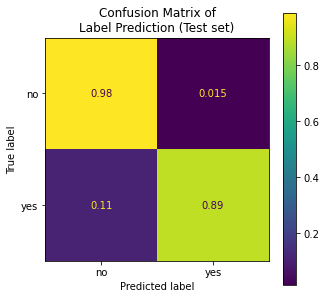

In [41]:
# Confusion matrix of Label results
fig, ax=plt.subplots(1,1,figsize=(5,5))
plt.grid(False)
# Plot the confusion matrix normalizing over the true values (over the rows)
cm = confusion_matrix(y_label_test, y_label_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot(ax=ax, cmap='viridis')
plt.title('Confusion Matrix of\nLabel Prediction (Test set)')
plt.show()

### Dataset Preprocessed

Now let's try instead to work with preprocessed data.

In [42]:
model.fit(X_pca_train_pp, y_label_train)
print('The Model is trained well with the given images')
model.best_params_

The Model is trained well with the given images


{'C': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}

Just by looking at the accuracy we can see an improvement.

In [43]:
y_label_train_pred = model.predict(X_pca_train_pp)
train_acc = accuracy_score(y_label_train, y_label_train_pred)
print("Train set accuracy:", train_acc)
y_label_test_pred = model.predict(X_pca_test_pp)
test_acc = accuracy_score(y_label_test, y_label_test_pred)
print("Test set accuracy :", test_acc)

Train set accuracy: 1.0
Test set accuracy : 1.0


Let's save the results.

In [44]:
models_result.append(['SVM (Preprocessed)',train_acc, test_acc])

Here we can look at the confusion matrix.

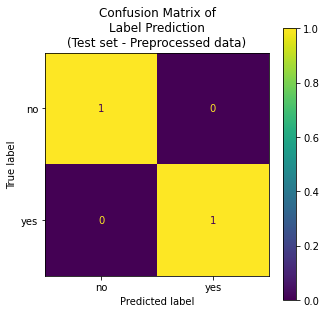

In [45]:
# Confusion matrix of Label results
fig, ax=plt.subplots(1,1,figsize=(5,5))
plt.grid(False)
# Plot the confusion matrix normalizing over the true values (over the rows)
cm = confusion_matrix(y_label_test, y_label_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no', 'yes'])
disp.plot(ax=ax, cmap='viridis')
plt.title('Confusion Matrix of\nLabel Prediction\n(Test set - Preprocessed data)')
plt.show()

## Model results

As expected, results show the high improvements for label classification simply adding preprocessing.

In [46]:
pd.DataFrame(data = models_result, columns=['Model', 'Train accuracy', 'Test accuracy'])

,Model,Train accuracy,Test accuracy
0,SVM,0.94,0.94
1,SVM (Preprocessed),1.00,1.00


# Save and Read model

## Saving best model

Let's save only the last model which is the best one (more accurate in the test set with 0 to 3 sources)

In [47]:
# import joblib

In [48]:
# joblib.dump(model, 'thresholdModel.pkl')

In [49]:
# joblib.dump(pca, 'pca_for_thresholdModel.pkl')

## Read model

In [50]:
# model = joblib.load('thresholdModel.pkl')
# pca = joblib.load('pca_for_thresholdModel.pkl')

# Centroid Extractor Model 

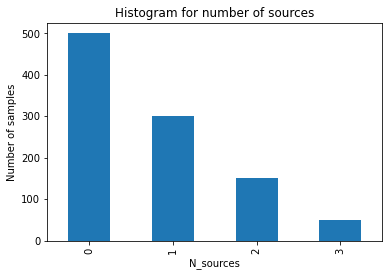

In [51]:
plt.title('Histogram for number of sources')
plt.ylabel('Number of samples')
df.groupby(['File_name', 'N_sources'], as_index=False).count() \
  .groupby('N_sources')['N_sources'].count()                   \
  .plot.bar()
plt.show()

This function returns simply a boolean value which tells us if it is or it is not present at least one source. This is done by using the model presented before.

In [52]:
def containsSource(X_preprocessed):
    # data preprocessed are flattened
    X_flt = X_preprocessed.reshape(1, -1)
    # using pca model, transform the data flattened
    X_pca = pca.transform(X_flt)
    # return the prediction in boolean form
    # [0] is added because predict return a list of prediction
    return (model.predict(X_pca) == 1)[0]

Following it is defigned the function for extract centroid from an image binarized. This is done, first of all by extracting contours and then, for each of them, computing its _moments_.

In [53]:
def findCentroid(X_pp, hdul):
    # extracts the contours from the image preprocessed
    contours = cv2.findContours(X_pp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    centroids = []
    for c in contours:
        # compute the moments up to the third order of the contours of the image
        M = cv2.moments(c)
        if M["m00"] != 0:
            # calculate x,y coordinate of centroid for the current contour
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            # get the skymap header
            wcs = WCS(hdul[0].header)
            # convert the pixel integer coordinates in astronomycal coordinates 
            wcs_coords = wcs.pixel_to_world(cX, cY)
            centroids.append(wcs_coords)
    return centroids

This following function computes the centroid if and only if the image si classified as having at least one source otherwise it returns an empty list.

In [54]:
def getCentroids(X, hdul):
    # checks if the image X contains at least one source, 
    # preprocess_SVM is applyed for this task
    if containsSource(preprocess_SVM(X)):
        # extract sources' centroids, preprocess preprocess_EXS 
        # is applyied 
        return findCentroid(preprocess_EXS(X), hdul)
    else:
        return[]

Here we can see the defintion of the function used for computing the prediction error for predicted and real coordinates. For this goal `separation` from module `astropy` is used.

The function returns 
* the list of prediction angular errors between sources predicted and real matched (`angular_err`);
* the list of number of mismatch errors, namely the amount of real sources which have not a correspondence in predicted list (False Negative - FN) + the amount of predicted  sources which have not a correspondance in the real sources (False Positive - FP) (`mismatch_err`);
* the list <predicted source, real source, file name> (`results`).

In [55]:
def angularError(cntr_true, cntr_pred):
    # let's copy both the list
    cntr_pred1 = cntr_pred.copy()
    cntr_true1 = cntr_true.copy()
    # intializes the outputs
    mismatch_err = 0
    angular_err  = []
    results = []
    # iterates from the start of the list of predicted sources until one of the two
    # list of sources doesn't allow a match amoung their element
    i = 0
    F_esc = False
    while (i<len(cntr_pred)) and (not (F_esc)):
        l = []
        # select the current predicted source centroid
        cpred = cntr_pred[i]
        # iterates over all the remained real centroid in the copied list
        for ctrue in cntr_true1:
            # memorizes the predicted angular error between predicted and 
            # real sources' centroids
            l.append(cpred.separation(ctrue).radian)
        # if the list of matches is not empty
        if not l == []:
            # searches the minimum distance amoung real-predicted sources' centroid
            id_match = np.argmin(l)
            best_sep = l[id_match]
            # saves the best distance and couple real-predicted sources' centroid 
            angular_err.append(best_sep)
            results.append([cpred, cntr_true1[id_match], best_sep])
            # remove the elements of the couple real-predicted sources' centroid  
            # from their lists
            cntr_true1.remove(cntr_true1[id_match])
            cntr_pred1.remove(cpred)
        # if one of the two list has not anymore centroids it means that there
        # some mismatch so F_esc is update
        F_esc = len(cntr_true1)*len(cntr_pred1) == 0
        i += 1
    # saves the absolute value of the difference between the two lists
    mismatch_err = abs(len(cntr_pred) - len(cntr_true))
    # adds the lines with None value for real centroid coordinates without match
    # and None value for the prediction angular error
    for ctrue in cntr_true1:
        results.append([None, ctrue, None])
    # adds the lines with None value for predicted centroid coordinates without
    # match and None value for the prediction angular error
    for cpred in cntr_pred1:
        results.append([cpred, None, None])
    return (angular_err, mismatch_err, results)

Finally let's predict the centroids and the results of the prediction.

## Extraction results

In [56]:
df_results = []
msm = []
y_coord_pred = []
# iterates over all the data of the test set
for i in range(len(X_data_test)):
    # open the skymap
    hdul = fits.open(X_file_test[i])
    # extracts the centroids
    coord_pred = getCentroids(X_data_test[i], hdul)
    # close the skymap
    hdul.close()
    # add in a list the coordinates predicted
    y_coord_pred.append(coord_pred)
    # computes the angular error, the number of mismatches and the coordinates tuple 
    (angular_err, mismatch_err, results) = angularError(y_coord_test[i], coord_pred)
    # saves the number of mismatches
    msm.append(mismatch_err)
    # saves the tuple in a list adding also the file name
    for r in results:
        r.append(X_file_test[i])
        df_results.append(r)
        
# shows the results obtained
df_results = pd.DataFrame(df_results, 
                          columns=['predCoords', 'trueCoords', 'predictionError', 'file'])
df_results.head()

,predCoords,trueCoords,predictionError,file
0,"<SkyCoord (ICRS): (ra, dec) in deg\n (86.03...","<SkyCoord (ICRS): (ra, dec) in deg\n (86.01...",0.000445,./data/dataset/skymaps/crab_sky299.fits
1,"<SkyCoord (ICRS): (ra, dec) in deg\n (82.63...","<SkyCoord (ICRS): (ra, dec) in deg\n (82.62...",0.000185,./data/dataset/skymaps/crab_sky673.fits
2,"<SkyCoord (ICRS): (ra, dec) in deg\n (82.16...","<SkyCoord (ICRS): (ra, dec) in deg\n (82.16...",0.000096,./data/dataset/skymaps/crab_sky028.fits
3,"<SkyCoord (ICRS): (ra, dec) in deg\n (85.56...","<SkyCoord (ICRS): (ra, dec) in deg\n (85.56...",0.000367,./data/dataset/skymaps/crab_sky232.fits
4,"<SkyCoord (ICRS): (ra, dec) in deg\n (85.40...","<SkyCoord (ICRS): (ra, dec) in deg\n (85.39...",0.000184,./data/dataset/skymaps/crab_sky307.fits


In [57]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   predCoords       179 non-null    object 
 1   trueCoords       181 non-null    object 
 2   predictionError  179 non-null    float64
 3   file             181 non-null    object 
dtypes: float64(1), object(3)
memory usage: 5.8+ KB


These are the only sources coordinates which didn't have a match. Let's observe the fact that there are not FP.

In [58]:
df_results[df_results['predCoords'].isna()]

,predCoords,trueCoords,predictionError,file
40,None,"<SkyCoord (ICRS): (ra, dec) in deg\n (81.04...",NaN,./data/dataset/skymaps/crab_sky142.fits
104,None,"<SkyCoord (ICRS): (ra, dec) in deg\n (86.58...",NaN,./data/dataset/skymaps/crab_sky250.fits


### Extreme case

In [59]:
def plot(img, title):
    plt.figure()
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.colorbar()
    plt.title(title)
    plt.show()

Could happen that some images are not well detected by the extractor, e.g. let's have a look at this extreme case. Assume to preprocess the following file. 

In [73]:
file = './data/dataset/skymaps/crab_sky142.fits'

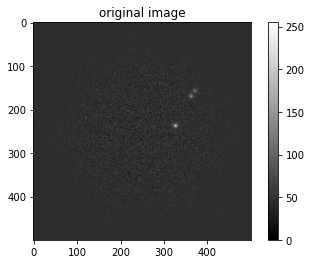

In [74]:
# open the skymap
hdul = fits.open(file)
# and convert it from .fits to .png
img = fits2png(hdul[0].data, file)
# close the skymap
hdul.close()
# plot the png generated image
plot(img, 'original image')

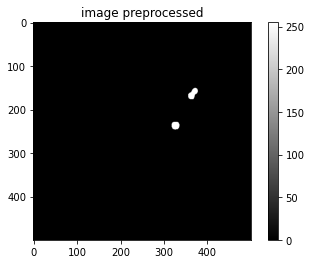

In [75]:
# preprocess the image
img = preprocess_EXS(img)
# plot the preprocessed image for centroid extraction
plot(img, 'image preprocessed')

### Angular prediction error

The following plot shows graphically the locality, spread and skewness of the predicted angular error. As you can see the error is almost always less than `1e-5`. Some outliers are also present but they depend from the proprierty of the problem. Indeed there are some weird cases where this algorithm fails to predict sources.

[]

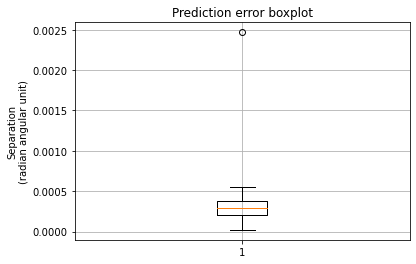

In [59]:
plt.title('Prediction error boxplot')
plt.grid(True)
plt.ylabel('Separation\n(radian angular unit)')
plt.boxplot(df_results.dropna()['predictionError'])
plt.plot()

In [60]:
df_results['predictionError'].describe()

count    179.000000
mean       0.000306
std        0.000202
min        0.000021
25%        0.000211
50%        0.000297
75%        0.000379
max        0.002469
Name: predictionError, dtype: float64

### Number of mismatch

Another important things to analyze is the number of mismtach which as it is possible to see, it shows very good results for what concern FP and FN.

In [64]:
gold_Nsources = [len(y_coord_test[i]) for i in range(len(y_coord_test))]
pred_Nsources = [len(y_coord_pred[i]) for i in range(len(y_coord_pred))]
print('Number of mismatch:', np.sum(msm), 'over', np.sum(gold_Nsources), 'sources')
test_acc = accuracy_score(gold_Nsources, pred_Nsources)
print("Test set accuracy predicting number of sources:", test_acc)

Number of mismatch: 2 over 181 sources
Test set accuracy predicting number of sources: 0.992


[]

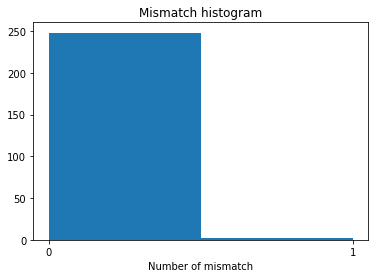

In [65]:
plt.xlabel('Number of mismatch')
plt.title('Mismatch histogram')
plt.hist(np.array(msm), bins=np.max(msm)+1)
plt.xticks(range(len(msm)))
plt.plot()

Going more in the details of these mistakes, the following confusion matrix shows the stability of the algorithm in predicting sources' coordinates when there is only 1 sources, while it seems quite accettable for two sources in one image and critical for 3 sources in the same image, resulting in a detection, more or less, in 2/3 of times. 

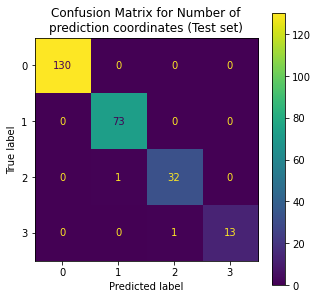

In [66]:
# Confusion matrix of Label results
fig, ax=plt.subplots(1,1,figsize=(5,5))
plt.grid(False)
# Plot the confusion matrix normalizing over the true values (over the rows)
cm = confusion_matrix([len(y_coord_test[i]) for i in range(len(y_coord_test))], 
                      [len(y_coord_pred[i]) for i in range(len(y_coord_pred))])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='viridis')
plt.title('Confusion Matrix for Number of\nprediction coordinates (Test set)')
plt.show()

# Appendix

## Moments

[Image moment - Wikipedia](https://en.wikipedia.org/wiki/Image_moment)

In image processing, computer vision and related fields, an **image moment** _is a certain particular weighted average (moment) of the image pixels' intensities_, or a function of such moments, usually chosen to have some attractive property or interpretation.

Image moments are useful to describe objects after segmentation. Simple properties of the image which are found via image moments include 
- area (or total intensity), 
- its centroid, 
- and information about its orientation.

For a 2D continuous function $f(x,y)$ the **moment** (sometimes called "raw moment") **of order (p + q)** is defined as:
$$ \int_{-\infty}^{+\infty} x^py^qf(x,y) \,dxdy $$

For $p,q = 0,1,2,...$ adapting this to scalar (greyscale) image with pixel intensities I(x,y), raw image moments $M_{ij}$ are calculated by:

$$\sum_x \sum_y x^iy^j I(x,y)$$



### Central moments

**Central moments** are defined as:
$$ \int_{-\infty}^{+\infty} (x-\bar{x})^p(y-\bar{y})^qf(x,y) \,dxdy $$
where $\bar{x}=\frac{M_{10}}{M_{00}}$ and $\bar{y}=\frac{M_{01}}{M_{00}}$ are the components of the **centroid**.

If $f(x, y)$ is a digital image, then the previous equation becomes
$$\sum_x \sum_y (x-\bar{x})^p(y-\bar{y})^qI(x,y)$$